# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

-- Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
-- Целевой признак:
- Price — цена (евро)


## Подготовка данных

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import time

In [44]:
df = pd.read_csv('D://Игорь/projects/autos.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете 354 369 строк и 16 столбцов. Формат у столбцов верный, за исключнием столбцов с датой, но из удалим из датасета т.к. никакой нужной информации для обучения моделей они не несут.

In [46]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [47]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В датасете имеются пропуски и не корректные данные, например год регистрации автомобиля, мощность или цена

In [48]:
#проверим максимальную дату выгрузки анкеты, чтобы понимать до какого года выпуска могут быть автомобили
df['DateCrawled'].max()

'2016-04-07 14:36:58'

Анкета была выгружена в 2016году

In [49]:
print('Количество дубликатов в датасете:', df.duplicated().sum())

Количество дубликатов в датасете: 4


Для начала удалим дубликаты в датасете

In [50]:
df = df.drop_duplicates()
print('Количество дубликатов в датасете:', df.duplicated().sum())

Количество дубликатов в датасете: 0


In [51]:
#Теперь удалим столбцы, которые для нашей модели не нужны: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated',
              'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
187841,5555,convertible,1990,manual,116,mx_reihe,100000,petrol,mazda,no
337996,1200,wagon,1999,manual,102,c_klasse,150000,gasoline,mercedes_benz,no
299569,750,small,1998,manual,60,corsa,150000,petrol,opel,no
121180,7700,wagon,2005,manual,231,5er,5000,gasoline,bmw,no
316686,3250,bus,2004,manual,101,meriva,150000,petrol,opel,no


In [52]:
#проверим, сколько строк с нулевой ценой
len(df[df['Price'] < 200])

17462

In [53]:
#В датасете есть данные с нулевой ценой. Т.к. эти данные являются целевым признаком, а заменить их нечем, то данные строки удалим
df = df[df['Price'] > 300].reset_index(drop=True)
len(df[df['Price'] == 0])

0

In [54]:
#посмотрим еще раз на пропуски
df.isna().sum()

Price                   0
VehicleType         29295
RegistrationYear        0
Gearbox             14422
Power                   0
Model               15679
Kilometer               0
FuelType            25297
Brand                   0
NotRepaired         58821
dtype: int64

In [55]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

У нас всего 3 значения в этом столбце: 'yes', 'no' и nan. Заменим 'yes' на 1, 'no' на 0, пропуски также заменим на 0, потому что раз в этой графе ничего не указали, значит, скорее всего, нечего было указывать и машина не ремонтировалась.

In [56]:
df['NotRepaired'] = df['NotRepaired'].replace({'yes':1, 'no':0})

In [57]:
df['NotRepaired'] = df['NotRepaired'].fillna(0).astype(int)

In [58]:
#проверим, прошла ли замена успешно
df['NotRepaired'].unique()

array([0, 1])

(1980.0, 2020.0)

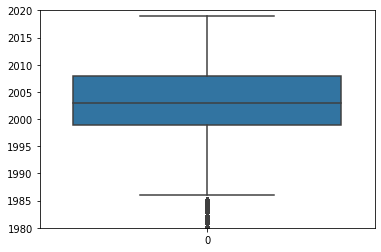

In [59]:
# Перавый автомобиль был выпущен в 1885г, по этому все даты до 1885 и после 2022г являются выбросами. Год регистрации автомобилья является 
# важной информацией, заменить ее на среднее мы не можем. Для определения границ выбросов построим boxplot
sns.boxplot(data=df['RegistrationYear'])
plt.ylim(1980, 2020)

На гистограмме видно, что выбросы начинаются до 1986 г. и после 2016 г. Отфильтруем эти данные.

In [60]:
print('Количество строк с некорректным годом:', len(df.query('RegistrationYear < 1986 or RegistrationYear > 2016')))

Количество строк с некорректным годом: 18768


In [61]:
df = df.query('RegistrationYear >= 1986 and RegistrationYear <= 2017')

Как мы помним из описательной таблицы в столбце `Power` минимальное значение является 0, а максимальное значение - 20 000. Это явно выбросы и поэтому нужно заменить эти данные медианными значениями в зависимости от модели автомобиля. На сегодняшний день самым мощным автомобилем является Lotus Evija с мощностью 2000 лошадиных сил. Но для определения границы выбросов построим boxplot.

(0.0, 400.0)

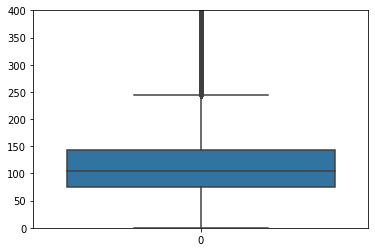

In [62]:
# в столбце 'Power' минимальное значение является 0, максимальное 20 000. Это явно выбросы и их нужнор заменить на медианные значения
# в зависимости от модели автомобиля. В данный момент самое мощное авто 2 000 лс. Но для определения границ выбросов построим boxplot
sns.boxplot(data=df['Power'])
plt.ylim(0, 400)

На гистограмме видно, что выбросы начинаются после 260 лошадиных сил.

In [63]:
print('Количество строк с некорректной мощностью:', len(df.query('Power == 0 or Power > 260')))

Количество строк с некорректной мощностью: 35252


In [64]:
#заменим некорректные значения в столбце на пропуски
df.loc[(df['Power'] <= 50) | (df['Power'] > 260), 'Power'] = None

In [65]:
#и теперь заменим пропуски на медианы в зависимости от модели
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df.isna().sum()

Price                   0
VehicleType         24883
RegistrationYear        0
Gearbox             13139
Power                4686
Model               14100
Kilometer               0
FuelType            22908
Brand                   0
NotRepaired             0
dtype: int64

In [66]:
df['Power'] = df['Power'].fillna(df.groupby('Brand')['Power'].transform('median'))
df.isna().sum()

Price                   0
VehicleType         24883
RegistrationYear        0
Gearbox             13139
Power                   0
Model               14100
Kilometer               0
FuelType            22908
Brand                   0
NotRepaired             0
dtype: int64

У нас остались пропуски в столбцах `VehicleType`, `Gearbox`, `Model` и `FuelType`. Данные столбца `Model` являются основными для обучения модели и восстановить эти данные не получится, поэтому заменим пропуски в данном столбце на тип модели `Other`. Данные столбцов `VehicleType`, `Gearbox` и `FuelType` заполним исходя из наиболее встречающихся данных в аналогичных моделях авто.

In [67]:
print('Процент пропуска данных по моделям от всего датасета:', (df['Model'].isna().sum()/len(df))*100)

Процент пропуска данных по моделям от всего датасета: 4.416144924721955


Пять процентов от датасета много, удалять нельзя. Заменим пропуски на `Other`.

In [68]:
df['Model'] = df['Model'].fillna('other')

#проверим количество оставшихся пропусков в данном столбце
df['Model'].isna().sum()

0

Остались пропуски еще в 3 столбцах. И так как в них содержатся категориальные данные, то заменить их медианой или средним не получится. Нужно посчитать самое частое количество значений для конкретной модели автомобиля в признаках, в которых будем заменять пропуски и заменить пропуски этим самым частым значением.

In [69]:
#напишем lambda-функцию, т.к. данные трансформируются именно функцией
#и стандартные функции метода transform нам здесь не подойдут
df['VehicleType'] = df['VehicleType']\
.fillna(df.groupby('Model')['VehicleType']\
.transform(lambda x: x.value_counts().idxmax())) 

In [70]:
df['Gearbox'] = df['Gearbox']\
.fillna(df.groupby('Model')['Gearbox']\
.transform(lambda x: x.value_counts().idxmax())) 

In [71]:
df['FuelType'] = df['FuelType']\
.fillna(df.groupby('Model')['FuelType']\
.transform(lambda x: x.value_counts().idxmax())) 

In [72]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [73]:
# код ревьюера
df.describe(include = 'all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
count,319283.000000,319283,319283.000000,319283,319283.000000,319283,319283.000000,319283,319283,319283.000000
unique,NaN,8,NaN,2,NaN,247,NaN,7,40,NaN
top,NaN,sedan,NaN,manual,NaN,other,NaN,petrol,volkswagen,NaN
freq,NaN,99262,NaN,255392,NaN,34410,NaN,213812,69144,NaN
mean,4738.385908,NaN,2003.660164,NaN,119.000266,NaN,128814.077167,NaN,NaN,0.089454
std,4508.926938,NaN,6.075948,NaN,44.820189,NaN,36621.416688,NaN,NaN,0.285398
min,301.000000,NaN,1986.000000,NaN,51.000000,NaN,5000.000000,NaN,NaN,0.000000
25%,1350.000000,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,0.000000
50%,3000.000000,NaN,2003.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,0.000000
75%,6800.000000,NaN,2008.000000,NaN,147.000000,NaN,150000.000000,NaN,NaN,0.000000


### Кодирование данных и разделение на выборки

In [74]:
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
272122,6600,coupe,2007,manual,140.0,civic,70000,petrol,honda,0
184066,999,wagon,1999,manual,144.0,omega,150000,petrol,opel,1
145198,4900,coupe,2000,manual,224.0,tt,150000,petrol,audi,0
197011,1700,sedan,2001,manual,101.0,astra,150000,petrol,opel,0
157906,10900,sedan,2016,manual,211.0,other,150000,petrol,porsche,0


Сохраним отдельно каегориальные признаки бенз кодирование, чтобы сравнить результат обучения модели на них с кодированием и без.
Если использовать прямое кодирование OHE, столбцов станет слишком много т.к. нужно кодировать бренд и модель, где много данных, по этому применим порядковое кодирование ОЕ к категориальным признакам. Но т.к. для линейной регрессии требуется прямое кодирование, то подготовиим отдельный датасет для линейной регрессии.

In [75]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.sample(5)

,Price,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
284188,500,2003,58.0,150000,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4043,3200,2004,95.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236983,16250,2011,211.0,50000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
266299,1500,1999,56.0,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
255416,560,1995,64.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [76]:
#Подготавливаем признаки для линейной регрессии\
features_ohe = df_ohe.drop(['Price'], axis=1)
target_ohe = df_ohe['Price'].reset_index(drop=True)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                           target_ohe, test_size=0.25,
                                                                                           random_state=12345) 
print('Размер обучающей выборки ОНЕ:', len(target_train_ohe))
print('Размер Тестовой выборки ОНЕ:', len(target_test_ohe))

Размер обучающей выборки ОНЕ: 239462
Размер Тестовой выборки ОНЕ: 79821


Для других трех моделей подготовим данные с порядковым кодированием и для сравнения без кодирования вообще

In [77]:
features = df.drop(['Price'], axis=1)
target = df['Price'].reset_index(drop=True)
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=12345)
print('Размер обучающей выборки:', len(target_train))
print('Размер Тестовой выборки:', len(target_test))

Размер обучающей выборки: 239462
Размер Тестовой выборки: 79821


In [78]:
df_oe = df.copy(deep=True)
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
encoder = OrdinalEncoder()

df_oe[category] = encoder.fit_transform(df_oe[category])

In [79]:
df_oe.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
299991,1450,4.0,1992,0.0,150.0,95.0,150000,6.0,20.0,0
291207,999,5.0,1999,1.0,60.0,83.0,150000,6.0,24.0,0
70271,9850,4.0,2005,0.0,218.0,11.0,150000,6.0,2.0,0
153807,8999,5.0,2017,1.0,60.0,173.0,50000,6.0,38.0,0
1794,950,4.0,1998,1.0,116.0,231.0,150000,6.0,24.0,0


Кодирование прошло успешнно. Проведем масштабирование признаковы и разделим выборку на обучающую и туствувую в соотношении 3:1

In [80]:
#Делим на призщнаки и целевой признак
features_oe = df_oe.drop(['Price'], axis=1)
target_oe = df_oe['Price'].reset_index(drop=True)

In [81]:
#Проводим стандартизацию данных scategory = scaled category
scategory = ['RegistrationYear', 'Power', 'Kilometer', 'NotRepaired']
scaler = StandardScaler()
features_ohe[scategory] = scaler.fit_transform(features_oe[scategory])
features_oe.sample(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
291844,5.0,2004,1.0,61.0,106.0,125000,6.0,32.0,0
94563,5.0,1995,1.0,65.0,83.0,150000,6.0,24.0,0
82553,7.0,2004,1.0,116.0,163.0,150000,4.0,31.0,0
78922,4.0,2004,1.0,105.0,42.0,150000,6.0,24.0,0
234001,5.0,2013,1.0,86.0,101.0,30000,6.0,31.0,0


In [82]:
# разделим выборку на обучающую и тестовую в соотношении 3к1
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
features_oe, target_oe, test_size=0.25, random_state=12345)

#Делаем масштабирование
features_train_oe[category] = encoder.fit_transform(features_train_oe[category])
features_test_oe[category] = encoder.fit_transform(features_test_oe[category])

print('Размер обучающей выборки OE:', len(target_train_oe))
print('Размер Тестовой выборки OE:', len(target_test_oe))

/tmp/ipykernel_182/2372267133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_oe[category] = encoder.fit_transform(features_train_oe[category])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Размер обучающей выборки OE: 239462
Размер Тестовой выборки OE: 79821


/tmp/ipykernel_182/2372267133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test_oe[category] = encoder.fit_transform(features_test_oe[category])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


### Вывод:
1. В датасете 354 369 стьрок и 16 столбцов. Формат у столбцов верный.ю
2. В датасете имеются пропуски и не корректныве данные, например год регистрации автомобиля, мощность или цена.
3. В датасете много пропусков и 4 дубликата.
4. были удалены пропуски и столбцы,которые для модели не нужны: DateCrawled, RegistratiunMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen.
5. Были удалены данные с нулевой ценой т.к. заменить их нечем
6. Были удалены столбцы с пропусками в данных о моделях, остальные бюыли заменены.
7. К датасету было применено порядковое кодирование, масштабирование данных, датасет был разделен на обучающую и валидационную выборки в соотношении 3 к 1

## Обучение моделей

Обучим 3 модели: линейню регрессию, случайный лес, LightGBM. 

In [83]:
#Для начала создадим функцию посчета RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

### Линейная регрессия

In [84]:
linear_model = LinearRegression()
start_lin_train = time.time()
linear_model.fit(features_train_ohe, target_train_ohe)
end_lin_train = time.time()

start_lin_pred = time.time()
linear_prediction = linear_model.predict(features_test_ohe)
end_lin_pred = time.time()

print('RMSE линейной регрессии:', rmse(target_test_ohe, linear_prediction))
print('Время обучения линейной регрессии:', end_lin_train - start_lin_train)
print('Время предсказания линейной регрессии:', end_lin_pred - start_lin_pred)

RMSE линейной регрессии: 2659.173900281638
Время обучения линейной регрессии: 92.8488187789917
Время предсказания линейной регрессии: 0.22026300430297852


RMSE линейной регрессии составляет 2659,17, время обучения - 31.05s, а на предсказание ушло 0.29s. 

### Случайный лес

In [ ]:
#Для подбора параметров используем GridSearchCV

#%time

forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators':range(10,50,10), 'max_depth':range(10,15)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs=-1)
forest_grid.fit(features_train_oe, target_train_oe)

print('Лучшие параметры для случайного леса:', forest_grid.best_params_)
print('Best score счлучайного леса:', forest_grid.best_score_)

In [ ]:
#Проверяем время обучени\ forest oe
forest_model = RandomForestRegressor(random_state=12345, max_depth=14, n_estimators=40)
start_for_train = time.time()
forest_model.fit(features_train_oe, target_train_oe)
end_for_train = time.time()
#Проверяем время прекдсказания forest oe
start_for_pred = time.time()
forest_prediction_oe = forest_model.predict(features_train_oe)
end_for_pred = time.time()

print('RMSE случайного леса:', rmse(target_train_oe, forest_prediction_oe))
print('Время обучения случайного леса:', end_for_train - start_for_train)
print('Время предсказания случайного леса:', end_for_pred - start_for_pred)


RMSE у случайного леса составляет 1469.10, это на много лучше чем у линейной регрессии. Время обучения составило 15.50s, время предсказания составило 1.45s.

### LightGBM :
— это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом. Он создан группой исследователей и разработчиков Microsoft. LightGBM известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней.


In [ ]:
#меняем тип категориальных данных на category
features_train[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']]=\
features_train[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']].astype('category')

In [ ]:
gbm_model_oe = LGBMRegressor(random_state=12345)
gbm_params_oe = {'n_estimators':[100,150], 'num_leaves':[10,15]}
gbm_grid_oe = GridSearchCV(gbm_model_oe, gbm_params_oe, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
gbm_grid_oe.fit(features_train_oe, target_train_oe)

print('Лучшие параметры LightGBM OE:', gbm_grid_oe.best_params_)
print('Best score LightGBM OE:', gbm_grid_oe.best_score_)

In [ ]:
#Проверяем время обчуения
gbm_model_oe = LGBMRegressor(randomstate=12345, n_estimators=150, num_leavs=15)
start_gbm_train = time.time()
gbm_model_oe.fit(features_train_oe, target_train_oe)
end_gbm_train = time.time()

#Время предсказания
start_gbm_pred = time.time()
gbm_prediction_oe = gbm_model_oe.predict(features_train_oe)
end_gbm_pred = time.time()

print('RMSE составляет:', rmse(target_train, gbm_prediction_oe))
print('Время обучение:', end_gbm_train - start_gbm_train)
print('Время предсказания:', end_gbm_pred - start_gbm_pred)

In [ ]:
#выборка без кодирования
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']  
gbm_model = LGBMRegressor(random_state=12345, n_estimators=150, num_leaves=15)
start_gbm_train = time.time()
gbm_model.fit(features_train, target_train, categorical_feature=cat_features, verbose=False)
end_gbm_train = time.time()

#проверим время предсказания LightGBM
start_gbm_pred
gbm_prediction = gbm_model.predict(features_train)
end_gbm_pred
print('RMSE LightGBM составляет:', rmse(target_train, gbm_prediction))
print('Время обучения LightGBM:', end_gbm_train - start_gbm_train)
print('Время предсказания LightGBM:', end_gbm_pred - start_gbm_pred)

LightGBM показал RMSE 1696.47 на закодированной выборке и RMSE 1675.82 на выборке без кодирования. При этом скорость обучения у него в разы выше, чем у всех предыдущих моделей, но скорость предсказаний самая низкая.

### Dummy Regressor

Для проверки адекватности раборты моделей обучим dummy модель

In [ ]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
dummy_prediction = dummy_model.predict(features_train)
print('RMSE dummy модели составляет:', rmse(target_train, dummy_prediction))

Все обученные модели лучше чем у Dummy

### Вывод:
1. Были обучены 3 модели: линейная регрессия, случайный лес и LightGBM
2. Лучший результат RMSE у случайного леса - 1469.10, самая высокая скорость предсказаний у LightGBM, самая высокая  скорость обучения у Линейной регрессии.
3. Все модели показали результат лучше яем Dummy Regressor

## Анализ моделей

In [ ]:
#сделаем сравнительную таблицу с полученными данными
data={'Модель': ['Linear Regression', 'RandomForest', 'CatBoost OE', 'CatBoost', 'LightGBM OE', 'LightGBM', 'DummyModel'],
      'RMSE': [2683.46, 1487.57, 1575.14, '1548.22', 1811.71, '1701.26', 4507.91],
      'Время обучения модели':['26.96 s' , '17.12 s', '58.54 s', '63.21 s', '4.79 s', '4.96 s', '3.52 ms'],
      'Время предсказания модели' : ['0.14 s', '1.45 s', '0.21 s', '0.56 s', '2.02 s', '2.02 s', '3.52 ms']}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

Проверим работу случайного леса на тестовой выборке.

In [ ]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=12345)
model.fit(features_train_oe, target_train_oe)
prediction = model.predict(features_test_oe)
print('RMSE случайного леса составляет:', rmse(target_test_oe, prediction))

 На тестовой выборке получился результат хуже, чем на обучающей выборке, но всё равно это достаточно высокий результат.

In [ ]:
feature_names = features_oe.columns 
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=12345)
model.fit(features_train_oe, target_train_oe)
pred = model.predict(features_test_oe)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)
std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)
fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease")
fig.tight_layout()

### Вывод:
1. По результатам проведенного исследования можно сделать вывод, что градиентный бустинг по качеству предсказаний превосходит линейную регрессию.
2. Лучшей моделью по показателю качество работы/скорость является Случайный лес, потому что результат RMSE у него самый низких среди всех моделей.